In [7]:
import nltk                         # NLP toolbox
from os import getcwd
import pandas as pd  # Library for Dataframes
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt     # Library for visualization
import numpy as np
import spacy# Library for math functions
import re
from typing import Tuple, List, Dict

from utils import process_tweet, build_freqs # Our functions for NLP

from rich import print


In [2]:
%%bash

# download the statistical model for tokenization
# python -m spacy download en_core_web_sm


In [3]:
nlp = spacy.load('en_core_web_sm')


## Load the NLTK sample dataset


In [4]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
tweets = all_positive_tweets + all_negative_tweets # concatenate tweets


# Data Pre-Processing

## Split the dataset into train and test sets

- 20% of the dataset goes into the test set
- 80% of the dataset goes into the train set

In [6]:
# Split the dataset into training and validation sets
train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
train_neg = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg
print(f"train_x.shape: {len(train_x)}")
print(f"test_x.shape: {len(test_x)}")


train_x.shape: 8000

test_x.shape: 2000

In [10]:
# Create label arrays
train_label_pos = np.ones((len(train_pos), 1), dtype=int)
train_label_neg = np.zeros((len(train_neg), 1), dtype=int)
train_label = np.vstack((train_label_pos, train_label_neg))

test_label_pos = np.ones((len(test_pos), 1), dtype=int)
test_label_neg = np.zeros((len(test_neg), 1), dtype=int)
test_label = np.vstack((test_label_pos, test_label_neg))

print(f"train_label.shape: {train_label.shape}")
print(f"test_label.shape: {test_label.shape}")


train_label.shape: (8000, 1)

test_label.shape: (2000, 1)

In [10]:
# data = pd.read_csv('../data/logistic_features.csv'); # Load a 3 columns csv file using pandas function
# data.head(10) # Print the first 10 data entries


In [24]:
# data exploration
# Choose a randomly selected tweet
sample_tweet = train_x[np.random.randint(0, len(train_x))]
print(sample_tweet)


Today's #FF - @CurlysCooking @beerandbaking @kneadtodough @vixyvonshock @mariannasbakery @collinscakery 
@sammiefeasting @NinaVictoriaCup :)

A tweet may contains the following information:
 - hashtags
 - urls
 - mentions

We will remove these information from the tweet text.

In [54]:
def remove_special_characters(tweet: str) -> Tuple[List[str], spacy.tokens.Doc]:
    """
    Function to remove special characters from a tweet and return a cleaned tweet and a Spacy Doc object.

    Parameters:
    tweet (str): The original tweet as a string.

    Returns:
    Tuple[List[str], spacy.tokens.Doc]: A tuple containing a list of lemmatized words from the cleaned tweet and a Spacy Doc object.
    """
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    # remove urls
    tweet = re.sub(r'http\S+', '', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove handles in tweet
    tweet = re.sub(r'@[^\s\n\r]+', '', tweet)

    # create a Spacy doc container for the tweets
    doc = nlp(tweet)
    # Lemmatize, remove stopwords and punctuation
    # List comprehension is used to iterate over the tokens in the doc
    # Only tokens that are not stop words, punctuation, or spaces are included in the clean_tweet list
    clean_tweet = [token.lemma_  for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return clean_tweet, doc


In [80]:
# test the function remove_special_characters
# test the function below
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', remove_special_characters(train_x[0])[0])


This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 

['FollowFriday', 'engage', 'member', 'community', 'week']

Count the number of words that words that exit in a positive and negative sentiment

In [12]:
def count_freq(tweets: List[str], labels: np.ndarray) -> Dict[Tuple[str, int], int]:
    """
    Function to count the frequency of each word in the tweets for each label.

    Parameters:
    tweets (List[str]): A list of tweets.
    labels (np.ndarray): A numpy array of labels corresponding to the tweets.

    Returns:
    Dict[Tuple[str, int], int]: A dictionary where the keys are tuples containing a word from a tweet and its corresponding label, and the values are the frequencies of these tuples in the tweets.
    """
    # convert labels from numpy array to list
    labels_list = np.squeeze(labels).tolist()
    freqs = {}
    # get a tweet and its corresponding label
    for tweet, label in zip(tweets, labels_list):
        # clean the tweet and get the list of words
        # clean_tweet, _ = remove_special_characters(tweet)
        clean_tweet = process_tweet(tweet)
        # iterate over the words in the cleaned tweet
        for word in clean_tweet:
            # create a pair of the word and its label
            pair = (word, label)
            # if the pair is not in the dictionary, get() method returns 0
            # increment the count of the pair in the dictionary by 1
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs


In [14]:
train_word_freqs = count_freq(train_x, train_label)
test_word_freqs = count_freq(test_x, test_label)
print(len(train_word_freqs))
print(len(test_word_freqs))
# print(f"train_word_freqs[('happy', 1)]: {train_word_freqs[('happy', 1)]}")


11427

4604

#### Logistic Regression: Regression and a Sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights". If you took the deep learning specialization, we referred to the weights with the 'w' vector.  In this course, we're using a different variable $\theta$ to refer to the weights.

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
We will refer to 'z' as the 'logits'.

<a name='1-2'></a>
### 1.2 - Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0. 
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [15]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Function to compute the sigmoid of z.

    Parameters:
    z (np.ndarray): Input value or array of values.

    Returns:
    np.ndarray: Sigmoid of the input value or array of values.
    """
    # Compute the sigmoid of z
    h = 1 / (1 + np.exp(-z))
    return h


In [16]:
# create a cost function for logistic regression
def cost_func(h: np.ndarray, y: np.ndarray) -> float:
    """
    Function to compute the cost of the logistic regression.

    Parameters:
    h (np.ndarray): The sigmoid of the input values.
    y (np.ndarray): The actual labels.

    Returns:
    float: The cost of the logistic regression.
    """
    # compute the cost
    m = y.shape[0]
    cost = (-1/m) *  ( np.dot(y.T, np.log(h)) + np.dot(( 1 -y).T, np.log( 1 - h)))
    return cost


#### Update the weights

To update your weight vector $\theta$, you will apply gradient descent to iteratively improve your model's predictions.
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


<a name='ex-2'></a>
### gradientDescent
Implement gradient descent function.
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [17]:
def gradientDescent(x: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float, num_iters: int) -> Tuple[float, np.ndarray]:
    """
    Function to perform gradient descent on the logistic regression model.

    Parameters:
    x (np.ndarray): Matrix of features which is (m,n+1).
    y (np.ndarray): Corresponding labels of the input matrix x, dimensions (m,1).
    theta (np.ndarray): Weight vector of dimension (n+1,1).
    alpha (float): Learning rate.
    num_iters (int): Number of iterations you want to train your model for.

    Returns:
    Tuple[float, np.ndarray]: The final cost and the final weight vector.
    """
    # get 'm', the number of rows in matrix x
    m = x.shape[0]

    for i in range(0, num_iters):

        # get z, the dot product of x and theta
        z = np.dot(x, theta)

        # get the sigmoid of z
        h = sigmoid(z)

        # calculate the cost function
        J = cost_func(h, y)

        # update the weights theta
        theta = theta - (alpha/m) * (np.dot(x.T, (h - y)))

    J = float(J)
    return J, theta


In [19]:
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")


/tmp/ipykernel_47619/2734493179.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


The cost after training is 0.67094970.

The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]

#### Expected output
```
The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]
```

# Extract Features for Training

In [47]:
def extract_features(tweet: str, freqs: Dict[Tuple[str, int], int], process_tweet=process_tweet) -> np.ndarray:
    """
    Function to extract features from a tweet.

    Parameters:
    tweet (str): A string containing one tweet.
    freqs (Dict[Tuple[str, int], int]): A dictionary corresponding to the frequencies of each tuple (word, label).
    process_tweet (function): A function used to process the tweet.

    Returns:
    np.ndarray: A feature vector of dimension (1,3).
    """
    # process_tweet tokenizes, stems, and removes stopwords
    word_l  = process_tweet(tweet)

    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3)

    # bias term is set to 1
    x[0] = 1

    # loop through each word in the list of words
    for word in word_l:

        # increment the word count for the positive label 1
        x[1] += freqs.get((word, 1), 0)

        # increment the word count for the negative label 0
        x[2] += freqs.get((word, 0), 0)

    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x


In [44]:
# Check your function
# test 1
# test on training data
tmp1 = extract_features(train_x[0], train_word_freqs, process_tweet)
print(tmp1)


[[1.000e+00 3.133e+03 6.100e+01]]

In [24]:
# test 2:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features('blorb bleeeeb bloooob', train_word_freqs)
print(tmp2)


[[1. 0. 0.]]

#### Expected output
```
[[1. 0. 0.]]
```

<a name='3'></a>
## 3 - Training Your Model

To train the model:
* Stack the features for all training examples into a matrix X. 
* Call `gradientDescent`, which you've implemented above.

This section is given to you.  Please read it for understanding and run the cell.

In [25]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], train_word_freqs)

# training labels corresponding to X
Y = train_label

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")


/tmp/ipykernel_47619/2734493179.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


The cost after training is 0.22521264.

The resulting vector of weights is [6e-08, 0.0005382, -0.0005583]

<a name='4'></a>
## 4 -  Test your Logistic Regression

It is time for you to test your logistic regression function on some new input that your model has not seen before. 
<a name='ex-4'></a>
###  predict_tweet
Implement `predict_tweet`.
Predict whether a tweet is positive or negative.

* Given a tweet, process it, then extract the features.
* Apply the model's learned weights on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [48]:
def predict_tweet(tweet: str, freqs: Dict[Tuple[str, int], int], theta: np.ndarray) -> float:
    """
    Function to predict whether a given tweet is positive or negative.

    Parameters:
    tweet (str): A string containing one tweet.
    freqs (Dict[Tuple[str, int], int]): A dictionary corresponding to the frequencies of each tuple (word, label).
    theta (np.ndarray): (3,1) vector of weights.

    Returns:
    float: The probability of a tweet being positive or negative.
    """
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)

    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred


In [50]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, train_word_freqs, theta)))


/tmp/ipykernel_47619/3751981410.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (tweet, predict_tweet(tweet, train_word_freqs, theta)))


I am happy -> 0.519275

I am bad -> 0.494347

this movie should have been great. -> 0.515980

great -> 0.516065

great great -> 0.532097

great great great -> 0.548063

great great great great -> 0.563930

**Expected Output**: 
```
I am happy -> 0.519275
I am bad -> 0.494347
this movie should have been great. -> 0.515979
great -> 0.516065
great great -> 0.532096
great great great -> 0.548062
great great great great -> 0.563929
```

In [51]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, train_word_freqs, theta)


array([0.83110764])

<a name='4-1'></a>
### 4.1 -  Check the Performance using the Test Set
After training your model using the training set above, check how your model might perform on real, unseen data, by testing it against the test set.

<a name='ex-5'></a>
### test_logistic_regression
Implement `test_logistic_regression`. 
* Given the test data and the weights of your trained model, calculate the accuracy of your logistic regression model. 
* Use your 'predict_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by m.


In [54]:
def test_logistic_regression(test_x: List[str], test_y: np.ndarray, freqs: Dict[Tuple[str, int], int], theta: np.ndarray, predict_tweet = predict_tweet) -> float:
    """
    Function to test the logistic regression model.

    Parameters:
    test_x (List[str]): A list of tweets.
    test_y (np.ndarray): (m, 1) vector with the corresponding labels for the list of tweets.
    freqs (Dict[Tuple[str, int], int]): A dictionary with the frequency of each pair (or tuple).
    theta (np.ndarray): Weight vector of dimension (3, 1).
    predict_tweet (function): A function used to predict the sentiment of a tweet.

    Returns:
    float: The accuracy of the model. It is calculated as the number of tweets classified correctly divided by the total number of tweets.
    """
    # the list for storing predictions
    y_hat = []

    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.mean(np.array(y_hat).reshape(-1, 1) == test_y)

    return accuracy


In [55]:
tmp_accuracy = test_logistic_regression(test_x, test_label, train_word_freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")


Logistic regression model's accuracy = 0.9950

<a name='5'></a>
## 5 -  Error Analysis

In this part you will see some tweets that your model misclassified. Why do you think the misclassifications happened? Specifically what kind of tweets does your model misclassify?

In [56]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_label):
    y_hat = predict_tweet(x, train_word_freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


Label Predicted Tweet

THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so 
stubborn on mouth soaping ! #NotHavingit :p

THE PROCESSED TWEET IS:
[
    'sure',
    'would',
    'good',
    'thing',
    '4',
    'bottom',
    'dare',
    '2',
    'say',
    '2',
    'miss',
    'b',
    'im',
    'gonna',
    'stubborn',
    'mouth',
    'soap',
    'nothavingit',
    ':p'
]

/tmp/ipykernel_47619/2636149090.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


1       0.48942981      b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap 
nothavingit :p'

THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu

THE PROCESSED TWEET IS:
["i'm", 'play', 'brain', 'dot', 'braindot']

1       0.48418981      b"i'm play brain dot braindot"

THE TWEET IS: I'm playing Brain Dots : ) #BrainDots http://t.co/aOKldo3GMj http://t.co/xWCM9qyRG5

THE PROCESSED TWEET IS:
["i'm", 'play', 'brain', 'dot', 'braindot']

1       0.48418981      b"i'm play brain dot braindot"

THE TWEET IS: I'm playing Brain Dots : ) #BrainDots http://t.co/R2JBO8iNww http://t.co/ow5BBwdEMY

THE PROCESSED TWEET IS:
["i'm", 'play', 'brain', 'dot', 'braindot']

1       0.48418981      b"i'm play brain dot braindot"

THE TWEET IS: off to the park to get some sunlight : )

THE PROCESSED TWEET IS:
['park', 'get', 'sunlight']

1       0.49636406      b'park get sunlight'

THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p

THE PROCESSED TWEET IS:
['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']

1       0.48250522      b'uff itna miss karhi thi ap :p'

THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (

THE PROCESSED TWEET IS:
['u', 'prob', 'fun', 'david']

0       0.50988296      b'u prob fun david'

THE TWEET IS: pats jay : (

THE PROCESSED TWEET IS:
['pat', 'jay']

0       0.50040366      b'pat jay'

THE TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf

THE PROCESSED TWEET IS:
['belov', 'grandmoth']

0       0.50000002      b'belov grandmoth'

THE TWEET IS: Sr. Financial Analyst - Expedia, Inc.: (#Bellevue, WA) http://t.co/ktknMhvwCI #Finance #ExpediaJobs 
#Job #Jobs #Hiring

THE PROCESSED TWEET IS:
['sr', 'financi', 'analyst', 'expedia', 'inc', 'bellevu', 'wa', 'financ', 'expediajob', 'job', 'job', 'hire']

0       0.50648699      b'sr financi analyst expedia inc bellevu wa financ expediajob job job hire'

<a name='6'></a>
## 6 - Predict with your own Tweet

In [58]:
# Feel free to change the tweet below
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, train_word_freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else:
    print('Negative sentiment')


['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']

[0.48125421]

Negative sentiment

## Plot the regression line

In the same way, as part of this week's assignment, a Logistic regression model must be trained. The next cell contains the resulting model from the logistic regression training training. Notice that a list of 3 numeric values represents the whole model, that we have called _theta_ $\theta$.

In [59]:
# theta = [6.03518871e-08, 5.38184972e-04, -5.58300168e-04]
theta = np.squeeze(theta).tolist() # convert the array to list


## Plot the samples in a scatter plot

The vector theta represents a plane that split our feature space into two parts. Samples located over that plane are considered positive, and samples located under that plane are considered negative. Remember that we have a 3D feature space, i.e., each tweet is represented as a vector comprised of three values: `[bias, positive_sum, negative_sum]`, always having `bias = 1`. 

If we ignore the bias term, we can plot each tweet in a cartesian plane, using `positive_sum` and `negative_sum`. In the cell below, we do precisely this. Additionally, we color each tweet, depending on its class. Positive tweets will be green and negative tweets will be red.

/tmp/ipykernel_47619/3575212074.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1) # Plot a dot for each pair of words


Text(0, 0.5, 'Negative')

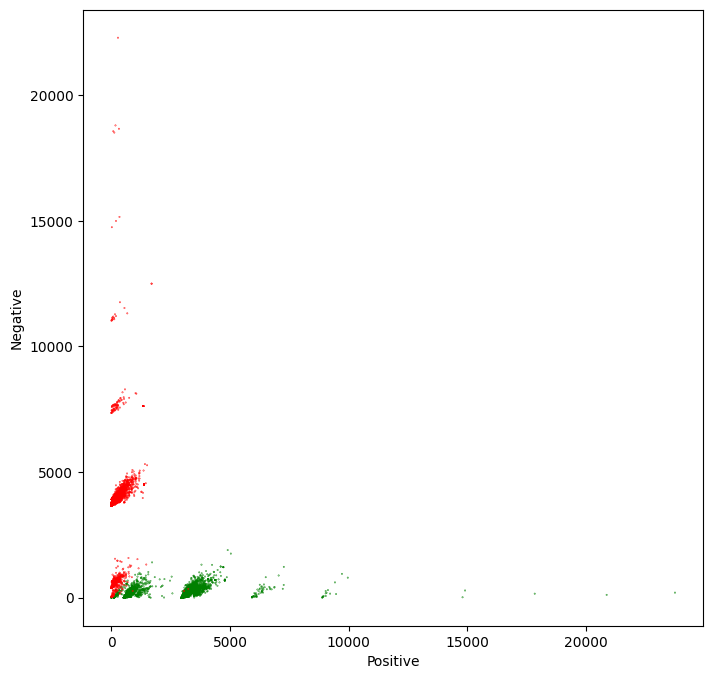

In [60]:
fig, ax = plt.subplots(figsize = (8, 8))
colors = ['red', 'green']

# color based on sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1) # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")


From the plot, it is evident that the features that we have chosen to represent tweets as numerical vectors allow an almost perfect separation between positive and negative tweets. So you can expect a very high accuracy for this model! 

## Plot the model alongside the data

We will draw a gray line to show the cutoff between the positive and negative regions. In other words, the gray line marks the line where $$ z = \theta * x = 0.$$
To draw this line, we have to solve the above equation in terms of one of the independent variables.

$$ z = \theta * x = 0$$
$$ x = [1, pos, neg] $$
$$ z(\theta, x) = \theta_0+ \theta_1 * pos + \theta_2 * neg = 0 $$
$$ neg = (-\theta_0 - \theta_1 * pos) / \theta_2 $$

The red and green lines that point in the direction of the corresponding sentiment are calculated using a perpendicular line to the separation line calculated in the previous equations (neg function). It must point in the same direction as the derivative of the Logit function, but the magnitude may differ. It is only for a visual representation of the model. 

$$direction = pos * \theta_2 / \theta_1$$

In [61]:
# It give a value in the negative axe as a function of a positive value
# f(pos, neg, W) = w0 + w1 * pos + w2 * neg = 0
# s(pos, W) = (-w0 - w1 * pos) / w2
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

# Equation for the direction of the sentiments change
# We don't care about the magnitude of the change. We are only interested
# in the direction. So this direction is just a perpendicular function to the
# separation plane
# df(pos, W) = pos * w2 / w1
def direction(theta, pos):
    return    pos * theta[2] / theta[1]


/tmp/ipykernel_47619/4057367353.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words


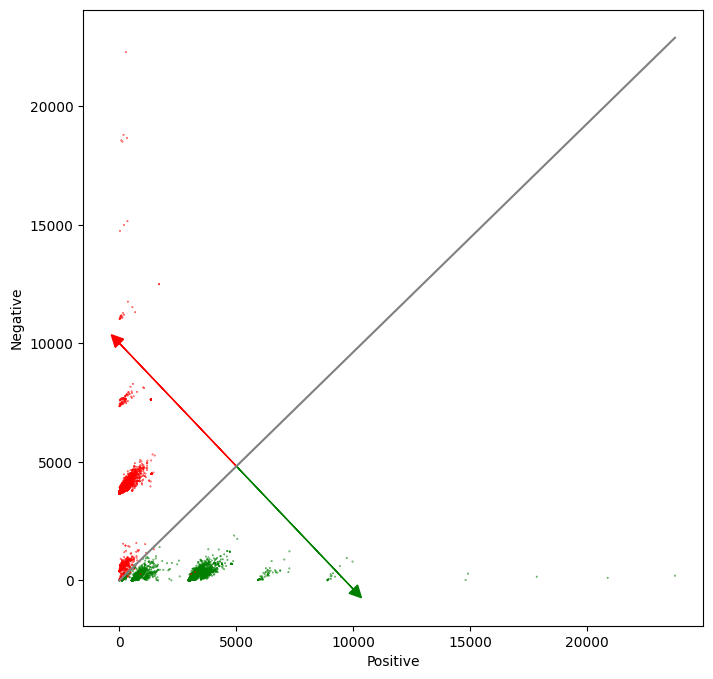

In [62]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart.
maxpos = np.max(X[:,1])

offset = 5000 # The pos value for the direction vectors origin

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray')

# Plot a green line pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=500, head_length=500, fc='g', ec='g')
# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500, fc='r', ec='r')

plt.show()
